### Funções e classes para análise de dados
- SteadyState é uma classe criada no âmbito do projeto de experimental IV para gerar modelos do s-timator automaticamente e realizar alguns cálculos essenciais, como o cálculo do valor máximo de cada pico de oscilação do NFkB.

In [5]:
from stimator import read_model
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math as m

def script(file,k,value):
    cut=file.split('\n')
    #cut[0] = cut[0] + str(k)
    for n in cut:
        if 'title' in n:
            cut[cut.index(n)] = n + ' ' + str(k) + '=' + str(value)
        if str(k) in n and ',' not in n:
            replace = n.split('=')
            replace[-1]=str(value)
            new = ' = '.join(replace)
            cut[cut.index(n)] = new
            final = '\n'.join(cut)
            return str(final)

def scan_prep(file,reaction,B):
    cut=file.split('\n')
    for n in cut:
        if 'init' in n:
            last = n
        if 'title' in n:
            cut[cut.index(n)] = n + str(reaction)
        if str(reaction) in n and ',' in n:
            add = n.split(', ')
            add[-1] = 'B*' + str(add[-1])
            add_new = ','.join(add)
            cut[cut.index(n)] = add_new
        if 'init' in n:
             cut[cut.index(n)] = ''
    #print(cut)
    final = cut.extend(['B = ' + str(B),'',last])
    final = '\n'.join(cut)
    return final

# Objects in python: also called instances, objects are general limits that contain some amount of code and data that will be further processed. They make up python's 
# Programming language and the interconversion of objects is precisely what defines coding.
# When creating a method or a constructor, the "self" argument is used so as for the function to act upon the instance. Basically, having "self" as an argument is the same saying
# Class.Method(Instance), which is summarized as Instance.Method() (these are two equivalent forms; the method acts upon the instance.

class SteadyState():
    def __init__(self,model,change={},tf=1000,npoints=1000,outputs=[],scan=False): # A constructor that is used to insert instance variables (i.e., variables that are particular to the created object)
        self.model = model
        self.model_solve = read_model(model).solve(tf=tf,npoints=npoints,outputs=outputs) #Creates the "model" instance variable that is the solved model 
        if scan == True:
            self.model = model
            self.model_scan = read_model(model).scan(change,tf=tf,npoints=npoints,outputs=outputs) #Creates the "model" instance variable that is the scanned model
            self.model_solve = read_model(model).solve(tf=tf,npoints=npoints) #Creates the "model" instance variable that is the solved model 
        #print(f'St+eadyState constructed')
    def steady_scan(self,lists,stimuli,sensibility=False):
        sa_values = {}#Empty dictionary for sensibility values 
        ss_values = {}#Empty dictionary for steady-state values
    # The scan object is a result of applying the scan function to the model
    #The list requires is a list containing a string with the variables to be analyzed
    #The stimuli list is a list contaning different percentage values of change for a paramter as to determine the sensibility of the system to that parameter
    #The sensibility term is an option so as to decide if the sensibility analysis will be performed
        for n in lists: #For a variable in a list containing all variable in strings
            for x in range(0,len(self.model_scan)): #For a number assigined to all tested conditions
                ss=self.model_scan[x][n][-1] #Iterates through each test condition and each variable, evaluating it's Steady-State(SS) value
                ss_values.update({n+str(x):ss})  #Adds this value to a dictionary
        if sensibility == True: #Condition to peform a sensibility analysis
            for n in lists:
                for x in range(0,len(self.model_scan)):
                    ssn=ss_values[n+str(x)] #Steady-state in a specific condition
                    ss0=ss_values[n+'0'] #Steady-state in the first "normal" condition
                    #print(ssn,ss0)
                    sa=((ssn-ss0)/ss0)/(stimuli[x]-1) #Calculated sensibility change due to changes in a parameter (defined by the percentage change in this parameter, B)
                    sa_values.update({n+str(x):sa})
            return pd.DataFrame([ss_values, sa_values],index=['SS','SA']).transpose() #Creates a DataFrame from the SS values and the SA values for each variable in each tested condition
        else:
            return ss_values

    def response_rate_max(self,variables):
        # Variables: list of strings containing the variables from the model to be analyzed.
        split = str(self.model_solve).split('\n') #Transform he model results into a list of strings, each element of the list corresponding to a line fo the results (the results are shown in a DataFrame)
        df = []
        for v in variables: #For v in a list containing the variables
            values_plus = []
            for i in range(0,len(self.model_solve[v])-2): 
                x = self.model_solve[v][i+1] - self.model_solve[v][i]
                y = self.model_solve[v][i+2] - self.model_solve[v][i+1]
                if x > 0 and y < 0:
                    values_plus.append(self.model_solve[v][i+1])
            link = {v:values_plus}
            data = pd.DataFrame(link)
            #print(data)
            temp_max=[]
            for line in str(self.model_solve).split('\n'):
                for max in data[v].tolist():
                    if str(max) in line:
                        time = line.split(' ')[0]
                        temp_max.append(time)
            dafr = pd.DataFrame(temp_max,data[v].tolist(),['time ' + str(v)])
            dafr.index.name = 'Max Value'
            df.append(dafr)
        return df

    def response_rate_min(self,variables):
        # Variables: list of strings containing the variables from the model to be analyzed.
        split = str(self.model_solve).split('\n') #Transform he model results into a list of strings, each element of the list corresponding to a line fo the results (the results are shown in a DataFrame)
        df = []
        for v in variables: #For v in a list containing the variables
            values_minus = []
            for i in range(0,len(self.model_solve[v])-2): 
                x = self.model_solve[v][i+1] - self.model_solve[v][i]
                y = self.model_solve[v][i+2] - self.model_solve[v][i+1]
                if x < 0 and y > 0:
                    values_minus.append(self.model_solve[v][i+1])
            link = {v:values_minus}
            data = pd.DataFrame(link)
            temp_min=[]
            for line in str(self.model_solve).split('\n'):
                for max in data[v].tolist():
                    if str(max) in line:
                        time = line.split(' ')[0]
                        temp_min.append(time)
            dafr = pd.DataFrame(temp_min,data[v].tolist(),['time ' + str(v)])
            dafr.index.name = 'Max Value'
            df.append(dafr)
        return df
    
    def script(self,k,value,tf=1000,npoints=10000): #Changes a parameter of the model to any number requested and creates another object with the new parameter
        # k = parameter to be changed
        # value = new value of the parameter
        # tf = final time of the simulation
        # npoints = total amount of points calculated
        cut=self.model.split('\n')
        #cut[0] = cut[0] + str(k)
        for n in cut:
            if 'title' in n:
                cut[cut.index(n)] = n + ' ' + str(k) + '=' + str(value)
            if str(k) in n and ',' not in n:
                replace = n.split('=')
                replace[-1]=str(value)
                new = ' = '.join(replace)
                cut[cut.index(n)] = new
                final = '\n'.join(cut)
            elif 'init' in n:
                init = n.split(',')
                for element in init:
                    if str(k) in element:
                        var_change = element.strip().split('=')
                        print(var_change)
                        var_change[-1] = str(value)
                        new = '='.join(var_change)
                        print(new)
                        replace[replace.index(element)] = new
                        replace = ','.join(replace)
                        cut[cut.index(n)] = replace
                        print(cut)
                        final = '\n'.join(cut)
            
        return SteadyState(final,tf=tf,npoints=npoints)
        
def sensibility_period(models):
    times = []
    for model in models:
        analysis = SteadyState(model,tf=20000,npoints=1000).response_rate_max(['NFkBnucTOT'])
        time = analysis['time NFkBnucTOT'].tolist()
        period_s = float(time[1]) - float(time[0])
        period_m = period_s/60
        times.append(period_m)
    
    sensibilities = []
    for time in times[1:]:
        sensibility = ((time - times[0])/times[0])/0.2
        sensibilities.append(sensibility)

    param_chang = []
    for model in models[1:]:
        split = model.split('\n')
        for line in split:
            if '(1' in line and 'title' not in line:
                parameter = line.split('=')[0].strip()
                param_chang.append(parameter)
    df = pd.DataFrame(zip(sensibilities,times[1:]),param_chang,columns=['Sensibility 20%','Period'])
    return df


### Exemplo de via metabólica: Exame de 2020

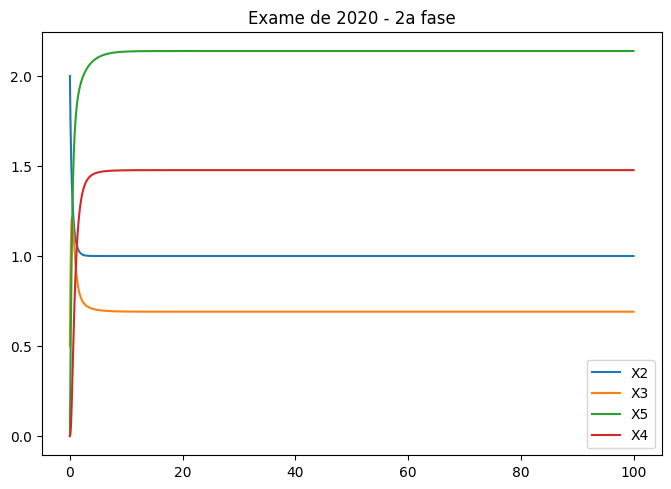

In [6]:
ex2020 = """
title: Exame de 2020 - 2a fase

r0: -> X2,  k1 
r01: -> X3, k0*K**n/(K**n+X4**n) + k2*X2**2
r11: X2 ->, k2*X2**2
r13: -> X5, k2*X2**2 + k3*X3**2
r21: X3 ->, k3*X3**2 + k4*X3*X5
r32: X5 ->, k4*X3*X5 
r33: -> X4, k4*X3*X5
r4: X4 ->, k5*X4 

n = 10
k0 = 1
k1 = 1
k2 = 1
k3 = 1
k4 = 1
k5 = 1
K = 2

init: (X2=2,X3=0.5,X5=0,X4=0)
"""

model = SteadyState(ex2020,tf=100,npoints=10000).model_solve.plot()
plt.show()

### Modelo minimal para visualização de oscilações
Equações gerais para implementação de cooperatividade e retroação:
- Hill:
    - Interação positiva: V*a^n/(K^n+a^n)
    - Interação negativa: V*K^n/(K^n+a^n)

A forma geral da equação é "V/((K/a)^n + 1). Para o caso de n > 1, a cooperação será positiva e o resultado será a primeria equação apresentada. Caso 0 < n < 1, a cooperação será negativa, resultando na segunda equação.


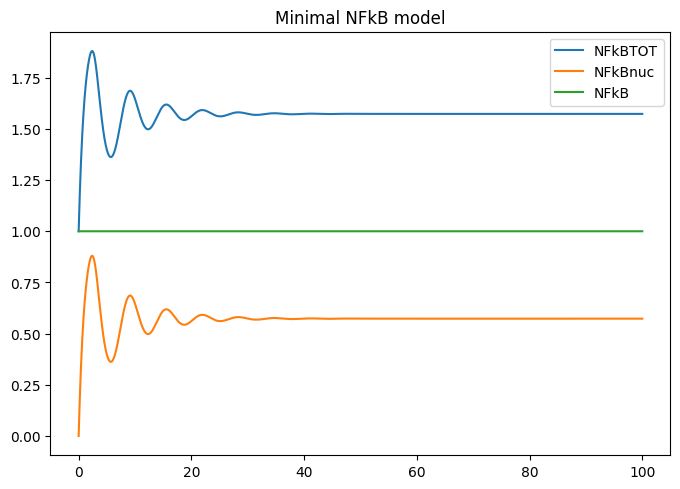

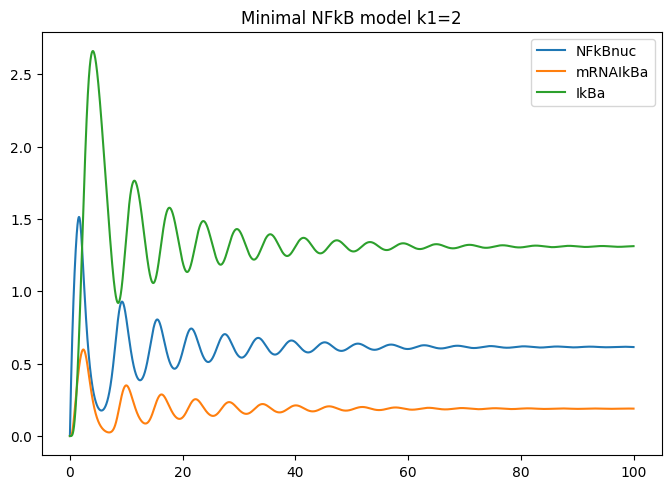

In [7]:
#________________________MODEL______________________
nfkb_mini = """

title Minimal NFkB model

r1: NFkB -> NFkBnuc, k1*NFkB*(Ki**n/(Ki**n+IkBa**n))
r2: NFkBnuc -> NFkB, k2*NFkBnuc
r3: -> mRNAIkBa,  k3*NFkBnuc**j/(Ka**j+NFkBnuc**j)
r4: mRNAIkBa ->, k4*mRNAIkBa
r5: -> IkBa, k5*mRNAIkBa
r6: IkBa ->, IkBamax*IkBa/(K+IkBa)

n = 3
j = 3
k1 = 1
k2 = 1
k3 = 1
k4 = 1
k5 = 3
IkBamax = 1
K = 1
Ki = 1
Ka = 1
NFkB = 1

~ NFkBTOT = NFkB + NFkBnuc

init: (NFkBnuc=0,IkBa=0,mRNAIkBa=0)
"""

#____________________________Multiple_Parameter_Scan___________________________
i=0 #switch
if i != 0:
    variable_range = ['k1',
                      'k2',
                      'k3',
                      'k4',
                      'k5']
    
    for parameter in variable_range:
        scan = SteadyState(nfkb_mini,{parameter:[1,5,10]},100,10000,scan=True)
        scan.model_scan.plot()
#______________________________________________________________________________

nfkb_mini_r5 = scan_prep(nfkb_mini,'r5','1')
model = read_model(nfkb_mini).scan({'IkBamax':[1,5,10]},tf=60,npoints=10000)
model_tot = read_model(nfkb_mini).solve(tf=100,npoints=10000,outputs=['NFkBTOT','NFkBnuc','NFkB'])
model_tot.plot()
plt.show()

i=1
if i != 0:
    SteadyState(nfkb_mini).script('k1','2',tf=100).model_solve.plot()
    plt.show()

### Modelo de Lipniacki para a sinalização do NFkB através de um estímulo com TNF-alpha

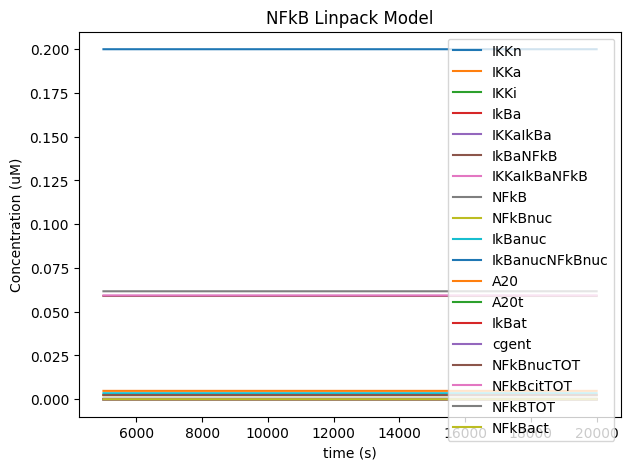

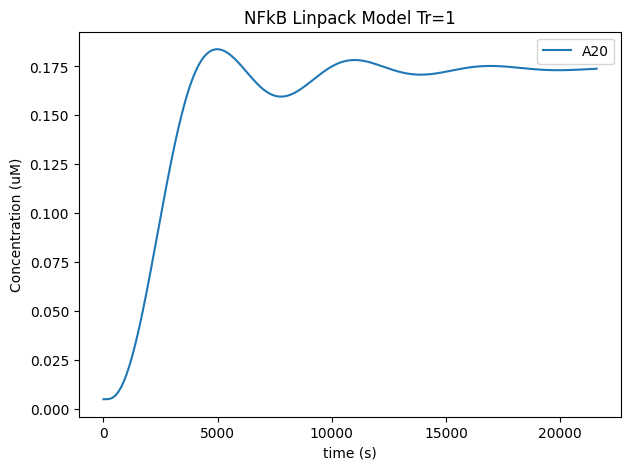

In [14]:
nfkb = """

title NFkB Linpack Model

r1: -> IKKn,                                kprod
r2: IKKn ->,                                IKKn*kdeg
r3: IKKn -> IKKa,                           IKKn*k1*Tr
r4: IKKa -> IKKi,                           IKKa*k3
r5: IKKa -> IKKi,                           A20*IKKa*k2*Tr
r6: IKKa ->,                                IKKa*kdeg
r7: IKKa + IkBa -> IKKaIkBa,                a2*IkBa*IKKa
r8: IKKaIkBa -> IKKa,                       IKKaIkBa*t1
r9: IKKa + IkBaNFkB -> IKKaIkBaNFkB,        a3*IkBaNFkB*IKKa
r10: IKKaIkBaNFkB -> IKKa + NFkB,           IKKaIkBaNFkB*t2
r11: IKKi ->,                               IKKi*kdeg
r12: IkBa + NFkB -> IkBaNFkB,               a1*IkBa*NFkB
r13: IkBaNFkB -> NFkB,                      c6a*IkBaNFkB
r141: NFkB -> ,                             i1*NFkB
r142: -> NFkBnuc,                           Kuv*i1*NFkB
r15: IkBanuc + NFkBnuc -> IkBanucNFkBnuc,   a1*IkBanuc*NFkBnuc
r16: -> A20,                                B*A20t*c4
r17: A20 ->,                                A20*c5
r18: -> A20t,                               c2
r19: -> A20t,                               c1*NFkBnuc
r20: A20t ->,                               A20t*c3
r21: -> IkBa,                               B*c4a*IkBat
r22: IkBa ->,                               c5a*IkBa
r231: IkBa -> ,                             IkBa*i1a
r232: -> IkBanuc,                           Kuv*IkBa*i1a
r241: IkBanuc ->,                           Kuv*e1a*IkBanuc
r242: -> IkBa,                              e1a*IkBanuc
r25: -> IkBat,                              B*c2a
r26: -> IkBat,                              B*c1a*NFkBnuc
r27: IkBat ->,                              c3a*IkBat
r281: IkBanucNFkBnuc ->,                    Kuv*e2a*IkBanucNFkBnuc
r282: -> IkBaNFkB,                          e2a*IkBanucNFkBnuc
r29: -> cgent,                              c2c
r30: -> cgent,                              c1c*NFkBnuc
r31: cgent ->,                              cgent*c3c
r32: -> NFkBnucTOT,                         Kuv*i1*NFkB
r33: NFkBnucTOT ->,                         Kuv*e2a*IkBanucNFkBnuc 
r34: -> NFkBcitTOT,                         e2a*IkBanucNFkBnuc
r35: NFkBcitTOT ->,                         i1*NFkB
r36: -> NFkBTOT,                            i1*NFkB + e2a*IkBanucNFkBnuc
r37: NFkBTOT ->,                            e2a*IkBanucNFkBnuc + i1*NFkB
r38: -> NFkBact,                            IKKaIkBaNFkB*t2 + c6a*IkBaNFkB + Kuv*i1*NFkB
r39: NFkBact ->,                            i1*NFkB + a1*IkBanuc*NFkBnuc + a1*IkBa*NFkB

B = 1
kprod = 2.5*10**(-5)
kdeg = 1.25*10**(-4)
k1 = 2.5*10**(-3)
Tr = 0
k3 = 1.5*10**(-3)
k2 = 1*10**(-1)
a2 = 2*10**(-1)
t1 = 1*10**(-1)
a3 = 1
t2 = 1*10**(-1)
a1 = 5*10**(-1)
c6a = 2*10**(-5)
i1 = 2.5*10**(-3)
c4 = 5*10**(-1)
c5 = 3*10**(-4)
c2 = 0
c1 = 5*10**(-7)
c3 = 4*10**(-4)
c4a = 5*10**(-1)
c5a = 1*10**(-4)
i1a = 1*10**(-3)
e1a = 5*10**(-4)
c2a = 0
c1a = 5*10**(-7)
c3a = 4*10**(-4)
e2a = 1*10**(-2)
c2c = 0
c1c = 5*10**(-7)
c3c = 4*10**(-4)
Kuv = 5

init:  (IKKn = 0.2,IKKa = 0,IKKi = 0,IkBa = 0.002503995,IKKaIkBa = 0,IkBaNFkB = 0.05900152,IKKaIkBaNFkB = 0,NFkB = 0.0003145073,NFkBnuc = 0.002288688,IkBanuc = 0.003435454,IkBanucNFkBnuc = 7.862682*10**(-5),A20 = 0.0047681,A20t = 2.86086*10**(-6),IkBat = 2.86086*10**(-6),cgent = 2.86086*10**(-6),NFkBnucTOT =0.002288688 + 7.862682*10**(-5),NFkBcitTOT = 0.05900152+0.0003145073, NFkBTOT =  0.05900152+0.0003145073+0.002288688 + 7.862682*10**(-5))
"""
# A20t = 2.86086*10**(-6)
# Tr é o estímulo (TNFaplha) 
# cgen -> é um produto qualquer expressado e não implica em nenhuma alteração nas variáveis do modelo
# O NFkB entra no núcleo apenas sob a forma de "monómero" (i.e., sem estar associado ao IkBa), porém apenas sai do núcleo associado ao complexo (sequestrado pelo seu inibidor)
nfkb_model = read_model(nfkb).solve(t0=5000,tf=20000,npoints=10000)
TNF1 = read_model(script(nfkb,'Tr','1')).solve(t0=0,tf=21600,npoints=100000,outputs=['A20']) #'IkBa','NFkBnuc',

#__________PLOT nfkb_model (Tr=0)________________
nfkb_model.plot(fig_size=(7,5))
plt.grid(False)
plt.xlabel('time (s)')
plt.ylabel('Concentration (uM)')
plt.show()
#________________________________________________
a = plt.style.available
#__________PLOT TNF1 (Tr=1)______________________
TNF1.plot(fig_size=(7,5))
plt.grid(False)
plt.xlabel('time (s)')
plt.ylabel('Concentration (uM)')
plt.show()
#_________________________________________________

### Determinação da relação entre o volume citosólico e nuclear (Kuv)
Para determinar a relação entre os volumes do núcleo e do citosol, é preciso analisar a relação de variação entre as espécies de NFkB em ambos os compartimentos num dado tempo. Inicialmente, quase todo o NFkB encontra-se no citosol sob a forma de um complexo com o seu inibidor, o IkBa (na simulação, sob a forma da espécie IkBaNFkB). Ao ativar a via, o NFkB é transportado para o núcleo até atingir um valor máximo. Este valor corresponde a quase todo o NFkB presente na célula, pelo que a razão entre o valor máximo do NFkB nuclear e o valor máximo do IkBaNFkB no início da simulação é uma boa aproximação (e pode ser usado como um indicador) da relação de volumes entre ambos os compartimentos.

In [13]:
TNF1_max = SteadyState(nfkb).script('Tr',1,tf=20000).script('Kuv',5,tf=20000,npoints=10000).response_rate_max(variables=['NFkBnuc','IkBaNFkB','NFkB','IkBanucNFkBnuc'])

for n in range(0,len(TNF1_max)):
    print(TNF1_max[n])


                 time NFkBnuc
Max Value                    
0.278915   1420.1420142014201
0.127910    8110.811081108111
0.095349   14163.416341634162
               time IkBaNFkB
Max Value                   
0.053055   4568.456845684568
0.041639   11021.10211021102
0.038458   17011.70117011701
                    time NFkB
Max Value                    
0.047409     148.014801480148
0.008395    6462.646264626462
0.005866   12325.232523252324
0.005307   18297.829782978297
          time IkBanucNFkBnuc
Max Value                    
0.000543     138.013801380138
0.003382    3088.308830883088
0.001227    5334.533453345334
0.001693     9610.96109610961
0.001384   15649.564956495647


### Sensibilidade da via face a alteração das quantidades iniciais de certas variáveis

In [88]:
TNF1_a = SteadyState(nfkb).script('Tr',1).script()


### Dados obtidos a partir do Western Blot

{0.0: 0.010354194, 900.0: 0.086085195, 1800.0: 0.185705307, 2700.0: 0.27723, 4500.0: 0.200424574, 5400.0: 0.144405548, 6300.0: 0.04978878, 7500.0: 0.073231101}


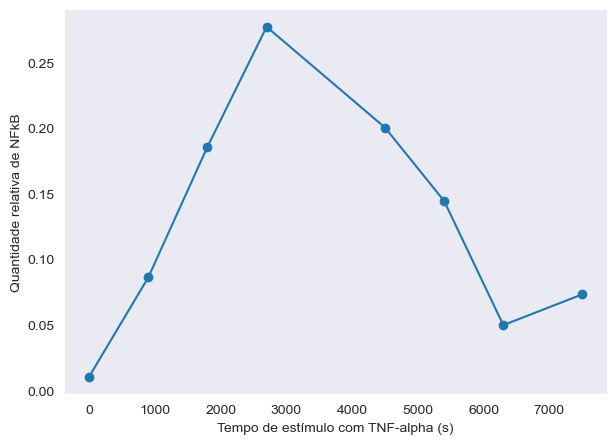

In [33]:
ft = open('stimator_w.txt')

data_fit = {}
for line in ft:
    data = line.split('\t')
    data_fit[float(data[0])] = float(data[1].strip())
print(data_fit)

with sns.axes_style('dark'):
    f, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(data_fit.keys(),data_fit.values())
    ax.plot(data_fit.keys(),data_fit.values())
    ax.set_ylabel('Quantidade relativa de NFkB')
    ax.set_xlabel('Tempo de estímulo com TNF-alpha (s)')
    plt.show()

### Sensibilidade: medir o período de oscilação do NFkB e análise de sensibilidade
- A partir deste ponto, o modelo com o nome "nfkb" Kuv = 4,27, valor ajustado para as células HeLa.

In [7]:
nfkb = """

title NFkB Linpack Model

r1: -> IKKn,                                kprod
r2: IKKn ->,                                IKKn*kdeg
r3: IKKn -> IKKa,                           IKKn*k1*Tr
r4: IKKa -> IKKi,                           IKKa*k3
r5: IKKa -> IKKi,                           A20*IKKa*k2*Tr
r6: IKKa ->,                                IKKa*kdeg
r7: IKKa + IkBa -> IKKaIkBa,                a2*IkBa*IKKa
r8: IKKaIkBa -> IKKa,                       IKKaIkBa*t1
r9: IKKa + IkBaNFkB -> IKKaIkBaNFkB,        a3*IkBaNFkB*IKKa
r10: IKKaIkBaNFkB -> IKKa + NFkB,           IKKaIkBaNFkB*t2
r11: IKKi ->,                               IKKi*kdeg
r12: IkBa + NFkB -> IkBaNFkB,               a1*IkBa*NFkB
r13: IkBaNFkB -> NFkB,                      c6a*IkBaNFkB
r141: NFkB -> ,                             i1*NFkB
r142: -> NFkBnuc,                           Kuv*i1*NFkB
r15: IkBanuc + NFkBnuc -> IkBanucNFkBnuc,   a1*IkBanuc*NFkBnuc
r16: -> A20,                                B*A20t*c4
r17: A20 ->,                                A20*c5
r18: -> A20t,                               c2
r19: -> A20t,                               c1*NFkBnuc
r20: A20t ->,                               A20t*c3
r21: -> IkBa,                               B*c4a*IkBat
r22: IkBa ->,                               c5a*IkBa
r231: IkBa -> ,                             IkBa*i1a
r232: -> IkBanuc,                           Kuv*IkBa*i1a
r241: IkBanuc ->,                           Kuv*e1a*IkBanuc
r242: -> IkBa,                              e1a*IkBanuc
r25: -> IkBat,                              B*c2a
r26: -> IkBat,                              B*c1a*NFkBnuc
r27: IkBat ->,                              c3a*IkBat
r281: IkBanucNFkBnuc ->,                    Kuv*e2a*IkBanucNFkBnuc
r282: -> IkBaNFkB,                          e2a*IkBanucNFkBnuc
r29: -> cgent,                              c2c
r30: -> cgent,                              c1c*NFkBnuc
r31: cgent ->,                              cgent*c3c
r32: -> NFkBnucTOT,                         Kuv*i1*NFkB
r33: NFkBnucTOT ->,                         Kuv*e2a*IkBanucNFkBnuc 
r34: -> NFkBcitTOT,                         e2a*IkBanucNFkBnuc
r35: NFkBcitTOT ->,                         i1*NFkB
r36: -> NFkBTOT,                            i1*NFkB + e2a*IkBanucNFkBnuc
r37: NFkBTOT ->,                            e2a*IkBanucNFkBnuc + i1*NFkB
r38: -> NFkBact,                            IKKaIkBaNFkB*t2 + c6a*IkBaNFkB + Kuv*i1*NFkB
r39: NFkBact ->,                            i1*NFkB + a1*IkBanuc*NFkBnuc + a1*IkBa*NFkB

B = 1
kprod = 2.5*10**(-5)
kdeg = 1.25*10**(-4)
k1 = 2.5*10**(-3)
Tr = 0
k3 = 1.5*10**(-3)
k2 = 1*10**(-1)
a2 = 2*10**(-1)
t1 = 1*10**(-1)
a3 = 1
t2 = 1*10**(-1)
a1 = 5*10**(-1)
c6a = 2*10**(-5)
i1 = 2.5*10**(-3)
c4 = 5*10**(-1)
c5 = 3*10**(-4)
c2 = 0
c1 = 5*10**(-7)
c3 = 4*10**(-4)
c4a = 5*10**(-1)
c5a = 1*10**(-4)
i1a = 1*10**(-3)
e1a = 5*10**(-4)
c2a = 0
c1a = 5*10**(-7)
c3a = 4*10**(-4)
e2a = 1*10**(-2)
c2c = 0
c1c = 5*10**(-7)
c3c = 4*10**(-4)
Kuv = 4.27

init: (IKKn = 0.2,IKKa = 0,IKKi = 0,IkBa = 0.002503995,IKKaIkBa = 0,IkBaNFkB = 0.05900152,IKKaIkBaNFkB = 0,NFkB = 0.0003145073,NFkBnuc = 0.002288688,IkBanuc = 0.003435454,IkBanucNFkBnuc = 7.862682*10**(-5),A20 = 0.0047681,A20t = 2.86086*10**(-6),IkBat = 2.86086*10**(-6),cgent = 2.86086*10**(-6),NFkBnucTOT =0.002288688 + 7.862682*10**(-5),NFkBcitTOT = 0.05900152+0.0003145073, NFkBTOT =  0.05900152+0.0003145073+0.002288688 + 7.862682*10**(-5))
"""

#_______________________Aquisição do período para o modelo original_____________________
test = SteadyState(script(nfkb,'Tr','1'),tf=20000,npoints=1000)
max = test.response_rate_max(['NFkBnuc'])
analysis = max['time NFkBnuc'].tolist()
#print(analysis)
period_s = float(analysis[1]) - float(analysis[0])
period_m_n = period_s/60
#_______________________Análise de sensibilidade________________________________________
 
SA0 = script(nfkb,'Tr','1') # Ativar o modelo com TNF-alpha
SA1 = script(SA0,'k1','2.5*10**(-3)*(1+0.2)')
SA2 = script(SA0,'k2','1*10**(-1)*(1+0.2)')
SA3 = script(SA0,'c6a','2*10**(-5)*(1+0.2)')
SA4 = script(SA0,'a1','5*10**(-1)*(1+0.2)')
SA5 = script(SA0,'a3','1.5*10**(-3)*(1+0.2)')
SA6 = script(SA0,'c1a','5*10**(-7)*(1+0.2)')
SA7 = script(SA0,'i1a','1*10**(-3)*(1+0.2)')
SA8 = script(SA0,'c4a','5*10**(-1)*(1+0.2)')
SA9 = script(SA0,'c3a','4*10**(-4)*(1+0.2)')
SA10 = script(SA0,'e2a','1*10**(-2)*(1+0.2)')
S11 = script(SA0,'c5','3*10**(-4)*(1+0.2)')
SA12 = script(SA0,'t2','1*10**(-1)*(1-0.2)')
SA13 = script(SA0,'i1','2.5*10**(-3)*(1-0.2)')
models = [SA0,SA1,SA2,SA4,SA5,SA6,SA7,SA8,SA9,SA12,SA13]

#______________________Medir o máximo para um determinado tempo________________________________

nfkb_max = SteadyState(SA0,tf=20000,npoints=1000)
nfkb_max_2 = SteadyState(SA5,tf=20000,npoints=1000)
print(nfkb_max.response_rate_max(['NFkBnucTOT']),nfkb_max_2.response_rate_max(['NFkBnucTOT']))
#plt.scatter(1441.4414414414414,0.277230)
sensibility_period([SA0,SA1,SA2,SA4,SA5,SA6,SA7,SA8,SA9,SA12,SA13])


              time NFkBnucTOT
Max Value                    
0.240658   1481.4814814814815
0.107048    8308.308308308307
0.086821   14634.634634634634               time NFkBnucTOT
Max Value                    
0.041870   2442.4424424424424
0.012823   14574.574574574575


,Sensibility 20%,Period
k1,0.000000,113.780447
k2,0.073314,115.448782
a1,-0.043988,112.779446
a3,3.885630,202.202202
c1a,-0.219941,108.775442
i1a,-0.087977,111.778445
c4a,-0.219941,108.775442
c3a,-0.043988,112.779446
t2,0.000000,113.780447
i1,0.014663,114.114114


### Ajuste do modelo: quantidade total de NFkB
- No modelo utilizado, a quantidade total de NFkB (i.e., de todas as suas formas existentes, seja livre ou em complexos) mantém-se constante. Para o modelo a seguir, Tr = 1.

### S-timator: estimativa dos parâmetros mais sensíveis da via do NFkB para enquadramento do modelo em células HeLa

In [8]:
nfkb_model =  """

title NFkB Linpack Model

r1: -> IKKn,                                kprod
r2: IKKn ->,                                IKKn*kdeg
r3: IKKn -> IKKa,                           IKKn*k1*Tr
r4: IKKa -> IKKi,                           IKKa*k3
r5: IKKa -> IKKi,                           A20*IKKa*k2*Tr
r6: IKKa ->,                                IKKa*kdeg
r7: IKKa + IkBa -> IKKaIkBa,                a2*IkBa*IKKa
r8: IKKaIkBa -> IKKa,                       IKKaIkBa*t1
r9: IKKa + IkBaNFkB -> IKKaIkBaNFkB,        a3*IkBaNFkB*IKKa
r10: IKKaIkBaNFkB -> IKKa + NFkB,           IKKaIkBaNFkB*t2
r11: IKKi ->,                               IKKi*kdeg
r12: IkBa + NFkB -> IkBaNFkB,               a1*IkBa*NFkB
r13: IkBaNFkB -> NFkB,                      c6a*IkBaNFkB
r141: NFkB -> ,                             i1*NFkB
r142: -> NFkBnuc,                           Kuv*i1*NFkB
r15: IkBanuc + NFkBnuc -> IkBanucNFkBnuc,   a1*IkBanuc*NFkBnuc
r16: -> A20,                                B*A20t*c4
r17: A20 ->,                                A20*c5
r18: -> A20t,                               c2
r19: -> A20t,                               c1*NFkBnuc
r20: A20t ->,                               A20t*c3
r21: -> IkBa,                               B*c4a*IkBat
r22: IkBa ->,                               c5a*IkBa
r231: IkBa -> ,                             IkBa*i1a
r232: -> IkBanuc,                           Kuv*IkBa*i1a
r241: IkBanuc ->,                           Kuv*e1a*IkBanuc
r242: -> IkBa,                              e1a*IkBanuc
r25: -> IkBat,                              B*c2a
r26: -> IkBat,                              B*c1a*NFkBnuc
r27: IkBat ->,                              c3a*IkBat
r281: IkBanucNFkBnuc ->,                    Kuv*e2a*IkBanucNFkBnuc
r282: -> IkBaNFkB,                          e2a*IkBanucNFkBnuc
r29: -> cgent,                              c2c
r30: -> cgent,                              c1c*NFkBnuc
r31: cgent ->,                              cgent*c3c

r32: -> NFkBnucTOT,                         Kuv*i1*NFkB
r33: NFkBnucTOT ->,                         Kuv*e2a*IkBanucNFkBnuc 
r34: -> NFkBcitTOT,                         e2a*IkBanucNFkBnuc
r35: NFkBcitTOT ->,                         i1*NFkB
r36: -> NFkBTOT,                            i1*NFkB + e2a*IkBanucNFkBnuc
r37: NFkBTOT ->,                            e2a*IkBanucNFkBnuc + i1*NFkB
r38: -> NFkBact,                            IKKaIkBaNFkB*t2 + c6a*IkBaNFkB + Kuv*i1*NFkB
r39: NFkBact ->,                            i1*NFkB + a1*IkBanuc*NFkBnuc + a1*IkBa*NFkB

B = 1
kprod = 2.5*10**(-5)
kdeg = 1.25*10**(-4)
Tr = 1
k3 = 1.5*10**(-3)
k2 = 1*10**(-1)
a2 = 2*10**(-1)
t1 = 1*10**(-1)
t2 = 1*10**(-1)
a1 = 5*10**(-1)
c6a = 2*10**(-5)
i1 = 2.5*10**(-3)
c4 = 5*10**(-1)
c5 = 3*10**(-4)
c2 = 0
c1 = 5*10**(-7)
c3 = 4*10**(-4)
c4a = 5*10**(-1)
c5a = 1*10**(-4)
i1a = 1*10**(-3)
e1a = 5*10**(-4)
c2a = 0
c1a = 5*10**(-7)
c3a = 4*10**(-4)
e2a = 1*10**(-2)
c2c = 0
c1c = 5*10**(-7)
c3c = 4*10**(-4)
Kuv = 4.27

find k1 in [0.00001,1.5] 
find a3 in [0.00001,1]

init: (IKKn = 0.2,IKKa = 0,IKKi = 0,IkBa = 0.002503995,IKKaIkBa = 0,IkBaNFkB = 0.05900152,IKKaIkBaNFkB = 0,NFkB = 0.0003145073,NFkBnuc = 0.002288688,IkBanuc = 0.003435454,IkBanucNFkBnuc = 7.862682*10**(-5),A20 = 0.0047681,A20t = 2.86086*10**(-6),IkBat = 2.86086*10**(-6),cgent = 2.86086*10**(-6),NFkBnucTOT =0.002288688 + 7.862682*10**(-5), NFkBcitTOT = 0.05900152+0.0003145073,NFkBTOT =  0.05900152+0.0003145073+0.002288688 + 7.862682*10**(-5))
"""

In [9]:
file = ['stimator_w.txt']

best_w = read_model(nfkb_model).estimate(file,names=['NFkBnucTOT'])

-- reading time courses -------------------------------
file c:\Users\jpedr\Desktop\Projetos Comp\Bioq_exp_IV\stimator_w.txt:
8 time points, 1 variables

Solving NFkB Linpack Model...
0   : 0.071303
1   : 0.071303
2   : 0.069809
3   : 0.069809
4   : 0.069809
5   : 0.069809
6   : 0.069809
7   : 0.069809
8   : 0.069809
9   : 0.069809
10  : 0.069809
11  : 0.069809
12  : 0.069809
13  : 0.065961
14  : 0.065961
15  : 0.065961
16  : 0.065961
17  : 0.065961
18  : 0.065961
19  : 0.065030
20  : 0.065030
21  : 0.065030
22  : 0.065030
23  : 0.065030
24  : 0.065030
25  : 0.065030
26  : 0.065030
27  : 0.065030
28  : 0.065030
29  : 0.065030
30  : 0.065030
31  : 0.065030
32  : 0.059729
33  : 0.059729
34  : 0.059729
35  : 0.059729
36  : 0.059729
37  : 0.059729
38  : 0.059729
39  : 0.059729
40  : 0.059729
41  : 0.059729
42  : 0.059729
43  : 0.059729
44  : 0.059729
45  : 0.059729
46  : 0.059729
47  : 0.059729
48  : 0.059729
49  : 0.059729
50  : 0.059729
51  : 0.059729
52  : 0.059729
refining last solutio

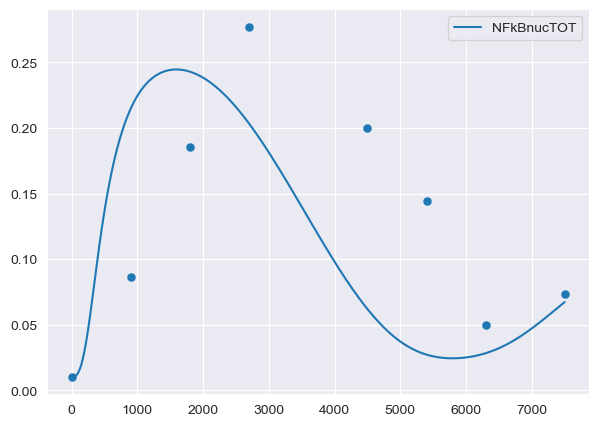


--- PARAMETERS           -----------------------------
k1	 0.000333137 +- 4.92817e-06
a3	    0.999903 +- 0.00331252

--- OPTIMIZATION         -----------------------------
Final Score	0.0586696
generations	52
max generations	200
population size	80
Exit by	Too many generations with no improvement


--- TIME COURSES         -----------------------------
Name		Points		Score
stimator_w.txt	8	0.0586696




In [10]:
with sns.axes_style('darkgrid'):
    best_w.plot(fig_size=(7,5))
    plt.title('')
    #plt.ylabel ('NFkB nuclear (uM)')
    #plt.xlabel('Tempo de estímulo com TNF-alpha (s)')
    plt.show()
print(best_w)

### Simulação com os novos parâmetros obtidos

- Análise dos parâmetros enzimáticos que formam possíveis inibidores da via

<class 'str'>
                   time cgent
Max Value                    
0.000174   3363.3633633633635
0.000100    10610.61061061061
0.000093   17017.017017017017
0.000092   23383.383383383385
0.000091    29789.78978978979
0.000091    36196.19619619619
{'IKKa': 0.0012868824979398092} 
 {'cgent': 9.074437006140158e-05}


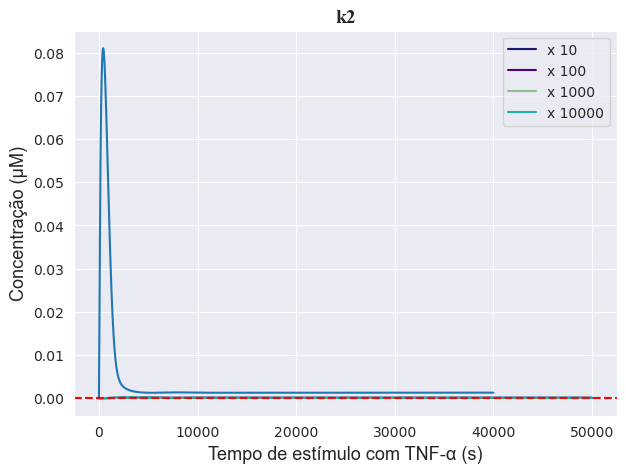

In [16]:
k1 = str(best_w.parameters[0][1])
a3 = str(best_w.parameters[1][1])
print(type(k1))
#Modelo original Lipniacki
nfkb_old = script(nfkb,'Tr','1')
#Modelo com os parâmetros alterados de acordo com os valores estimados
nfkb_new_c = script(script(script(nfkb,'Tr','1'),'k1',k1),'a3',a3)
nfkb_new_01 = script(script(script(script(nfkb,'Tr','1'),'k1',k1),'a3',a3+'*(1-0.)'),'k2','1*10**(-1)*(1+0)')
nfkb_new_001 = script(script(script(script(nfkb,'Tr','1'),'k1',k1),'a3',a3+'*(1-0.)'),'k2','1*10**(-1)*(1+0)')
nfkb_new_0001 = script(script(script(script(nfkb,'Tr','1'),'k1',k1),'a3',a3+'*(1-0.)'),'k2','1*10**(-1)*(1+0)')
nfkb_new = script(script(script(script(nfkb,'Tr','1'),'k1',k1),'a3',a3+'*(1-0.)'),'k2','1*10**(-1)*(1+0)')
# Inibição k1 -> (1-0.9999)
# Inibição a3 -> O mínimo ainda apresenta oscilações e, a partir de (1-0.9999), ele não é mais sensível a nenhum fator de diminuição
# Inibição i1 -> (1-0.9999)
# Inibição do k2 e k3 não resulta em uma diminuição de 10x do valor máximo do cgent 
model_old = read_model(nfkb_old).solve(tf=40000,npoints=100000,outputs=['IKKa'])
model_new_c = read_model(nfkb_new_c).solve(tf=36000,npoints=10000,outputs=['NFkBnuc','IkBa'])
model_new_01 = read_model(nfkb_new_01).solve(tf=50000,npoints=10000,outputs=['cgent'])
model_new_001 = read_model(nfkb_new_001).solve(tf=50000,npoints=10000,outputs=['cgent'])
model_new_0001 = read_model(nfkb_new_0001).solve(tf=50000,npoints=10000,outputs=['cgent'])
model_new = read_model(nfkb_new).solve(tf=50000,npoints=10000,outputs=['cgent'])
max_mnc = SteadyState(nfkb_new_c,tf=40000,npoints=1000).response_rate_max(['cgent'])

print(max_mnc)
print(model_old.last, '\n',model_new.last)

with sns.axes_style('darkgrid'):
    f, ax = plt.subplots(1,1,figsize=(7,5))
    ax.plot(model_old.t,model_old.data[0])
    #ax.plot(model_new_c.t,model_new_c.data[0],label='NF-kB nuclear',color='darkorange')
    #ax.plot(model_new_c.t,model_new_c.data[1],label='IkBα citosólico',color='indigo')
    ax.plot(model_new_01.t,model_new_01.data[0],label='x 10',color='midnightblue')
    ax.plot(model_new_001.t,model_new_001.data[0],label='x 100',color='indigo')
    ax.plot(model_new_0001.t,model_new_0001.data[0],label='x 1000',color='darkseagreen')
    ax.plot(model_new.t,model_new.data[0],label='x 10000',color='lightseagreen')
    ax.axhline(0.000174/10, ls='--', color='r')
    
    ax.set_ylabel('Concentração (μM)', fontsize='13',fontdict={'fontname': 'Arial',
                                                               'fontsize': 14})
    
    ax.set_xlabel('Tempo de estímulo com TNF-α (s)',fontsize='13',fontdict={'fontname': 'Arial',
                                                                            'fontsize': 14})
    
    ax.set_title('k2',fontdict={'fontname': 'Times New Roman',
                                'fontsize': 14,
                                'fontweight': 'bold'})
    ax.legend()

plt.show()

### Análise de sensibilidade dos parâmetros para o máximo de concentração do NF-kB nuclear